In [28]:
from collections import defaultdict
from dataclasses import dataclass
import os
import sys
import yaml
import time
import numpy as np
import scipy.io
import scipy.linalg
import scipy.sparse as sp
import matplotlib.pyplot as plt
from src.common import NDArrayFloat
from src.linalg import get_numpy_eigenvalues
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import RectBivariateSpline


In [29]:
def plot_2d_temperature(matrix, title="Temperature Plot of Matrix"):
  """
  Plots a 2D temperature map of a matrix, highlighting the largest elements.

  Args:
    matrix: The input numpy array (matrix).
    title: The title of the plot.
  """

  fig, ax = plt.subplots()

  # Plot the temperature map
  im = ax.imshow(matrix, cmap='hot', interpolation='nearest')

  # Add a colorbar
  cbar = fig.colorbar(im, ax=ax)
  cbar.set_label('Value')

  # Add labels and title
  ax.set_xlabel('Column Index')
  ax.set_ylabel('Row Index')
  ax.set_title(title)

  plt.show()

In [30]:
def generate_matrix(type: str, sparse: bool, size: int, min_val: float, max_val: float, grouping_factor: float = 0, density: float = 1) -> np.array:
  """Generates various types of REAL matrices with controlled value range and diagonal grouping.

  Args:
    type: The type of matrix to generate.
          Options: 'nonsymmetric', 'symmetric', 'normal', 'orthogonal'.
    sparse: Whether to generate a sparse matrix.
    size: The size of the matrix (size x size).
    min_val: Minimum value of the matrix elements.
    max_val: Maximum value of the matrix elements.
    grouping_factor: Controls the strength of diagonal grouping. 
                     0: No grouping.
                     Positive values: Increase grouping strength.

  Returns:
    A NumPy array representing the generated matrix.
  """
  
  seed = 42
  np.random.seed(seed)
  
  if type == 'nonsymmetric':
    if sparse:
      A = sp.rand(size, size, density=density, format='csr').toarray()
    else:
      A = np.random.rand(size, size)
    if grouping_factor > 0:
      for i in range(size):
        A[i, :] = A[i, :] * (1 + grouping_factor * i / (size-1)) # Scale based on distance and factor
    return A * (max_val - min_val) + min_val

  elif type == 'symmetric':
    if sparse:
      A = sp.rand(size, size, density=density, format='csr')
      A = (A + A.transpose()).toarray() / 2
    else:
      A = np.random.rand(size, size)
      A = (A + A.T) / 2
    if grouping_factor > 0:
      for i in range(size):
        for j in range(size):
          A[i, j] = A[i, j] * np.exp(-grouping_factor * abs(i - j) / (size - 1)) # Exponential decay from diagonal
    return A * (max_val - min_val) + min_val

  elif type == 'normal':
    if sparse:
      raise ValueError("Sparse normal matrices are not well-defined.")
    else:
      # Generate a symmetric matrix (guaranteed to be normal)
      A = np.random.rand(size, size)
      A = (A + A.T) / 2
      if grouping_factor > 0:
        for i in range(size):
          for j in range(size):
            A[i, j] = A[i, j] * np.exp(-grouping_factor * abs(i - j) / (size - 1)) # Exponential decay from diagonal
      return A * (max_val - min_val) + min_val

  elif type == 'orthogonal':
    if sparse:
      raise ValueError("Sparse orthogonal matrices are not well-defined.")
    else:
      Q, _ = np.linalg.qr(np.random.rand(size, size))
      if grouping_factor > 0:
        for i in range(size):
          Q[i, :] = Q[i, :] * (1 + grouping_factor * i / (size-1)) # Scale based on distance and factor
      return Q * (max_val - min_val) + min_val

  else:
    raise ValueError(f"Invalid matrix type: {type}")

In [31]:
def testing(A: np.array, name: str,show_plots: bool=True, function_name: str="numpy eig"):
  start_time = time.time()
  numpy_eigenvalues = np.linalg.eigvals(A)
  numpy_time = time.time() - start_time
  #numpy_eigenvalues.sort()

  print("NumPy eigvals:")
  print("  Time:", numpy_time, "seconds")

  
  if(show_plots):
    # Plot the differences
    numpy_eigenvalues_abs = np.abs(numpy_eigenvalues)
    plt.figure(figsize=(8, 6))
    plt.plot(numpy_eigenvalues_abs, label="NumPy eigvals abs unsorted")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.title("Eigenvalue Comparison")
    plt.legend()
    plt.show()

    
  return None

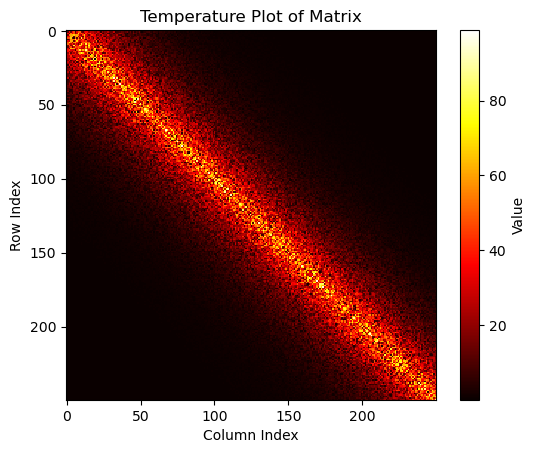

NumPy eigvals:
  Time: 0.01562190055847168 seconds


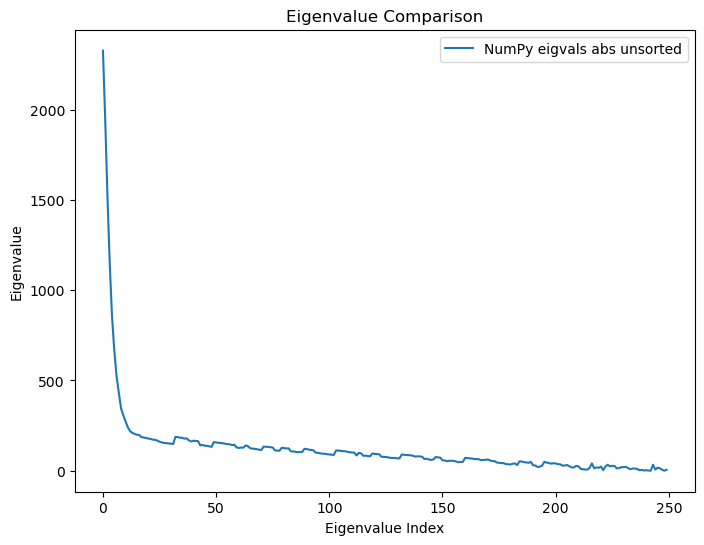

In [36]:
# 'symmetric'
A = generate_matrix(type='symmetric',sparse=True,size=250,min_val=0,max_val=100,grouping_factor=10)
plot_2d_temperature(A)
testing(A,"numpy eig")

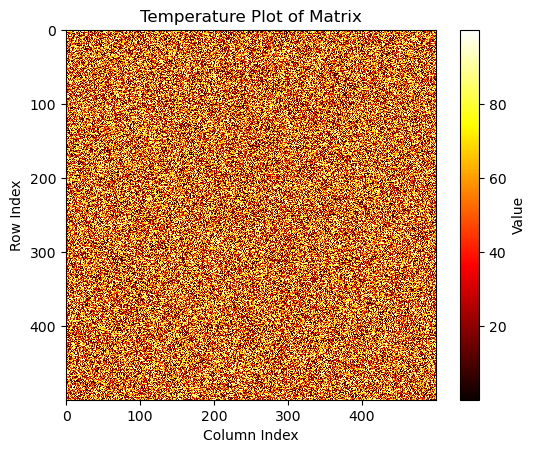

NumPy eigvals:
  Time: 0.13134264945983887 seconds


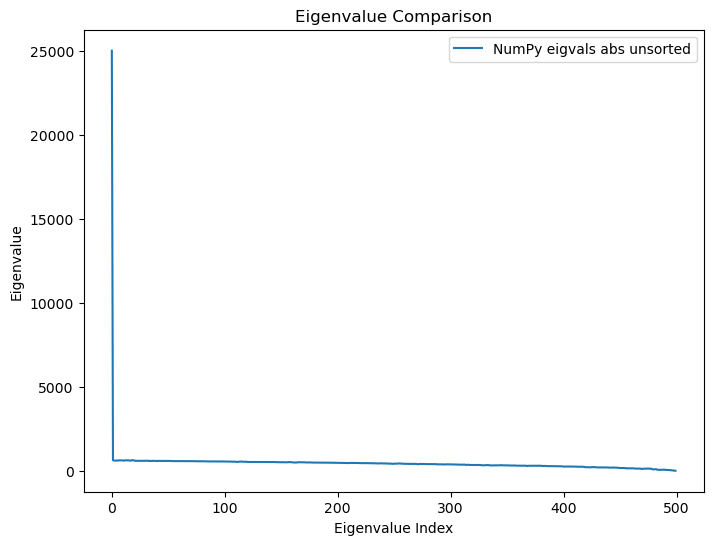

In [33]:
# 'nonsymmetric'
A = generate_matrix(type='nonsymmetric',sparse=False,size=500,min_val=0,max_val=100)
plot_2d_temperature(A)
testing(A,"numpy eig")

Numpy eig действительно находит первым делом неадекватно большие собственные числа, а потом смещается к равномернораспределенным числам.